In [103]:
import os
import nibabel as nb
import nilearn
from nilearn import plotting
from nilearn import glm
import numpy as np
from nilearn import image
from atlasreader import create_output
from matplotlib import pyplot as plt
import string
plt.rcParams['figure.dpi'] = 300

subjlevel_folder = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/processed/z_maps/subject-level'
mask_template = '/scratch/hyruuk/neuromod/shinobi2023/cneuromod.processed/smriprep/{}/anat/{}_space-MNI152NLin2009cAsym_desc-brain_mask.png'
annotations=['HIT', 'JUMP', 'Kill', 'HealthLoss']

In [5]:
def load_data(subjlevel_folder, annotations=['HIT', 'JUMP', 'Kill', 'HealthLoss']):
    data_dict = {'fpath_list': [],
                 'subject_list': [],
                 'annot_list': [],
                 'binarized_list': []}
    for annot in annotations:
        annot_folder = os.path.join(subjlevel_folder, annot)
        for file in os.listdir(annot_folder):
            if '.nii.gz' in file:
                fpath = os.path.join(annot_folder, file)
                data_dict['fpath_list'].append(fpath)
                thresholded_map = glm.threshold_stats_img(fpath, threshold=3)[0].get_fdata()
                binarized_map = np.where(thresholded_map != 0, 1, thresholded_map)
                data_dict['binarized_list'].append(binarized_map)
                data_dict['subject_list'].append(file.split('_')[0])
                data_dict['annot_list'].append(annot)
    return data_dict

data_dict = load_data(subjlevel_folder)


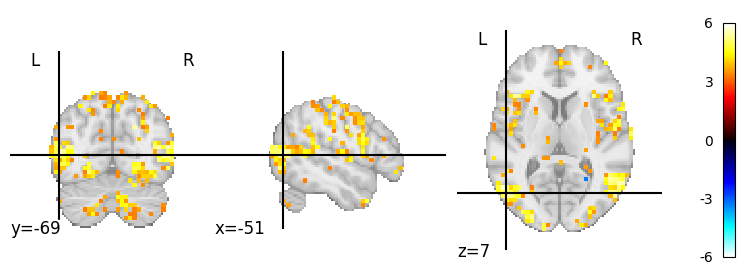

In [46]:
# Plot one beta map just to check
plotting.plot_stat_map(glm.threshold_stats_img(data_dict['fpath_list'][0], threshold=3)[0])

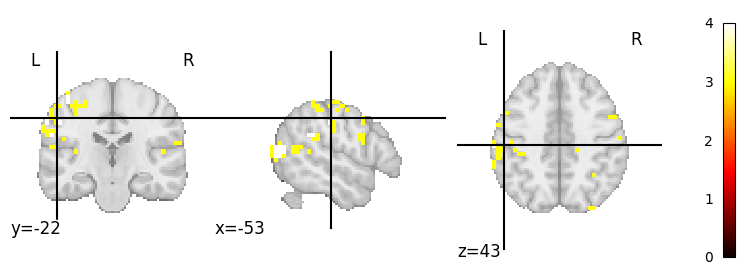

In [6]:
def get_top_voxels(data_dict, annot_to_plot):
#annot_to_plot = 'HIT'
    sublist = [data_dict['binarized_list'][idx] for idx, annot in enumerate(data_dict['annot_list']) if annot == annot_to_plot ]
    summed_image = image.new_img_like(nb.load(data_dict['fpath_list'][0]), 
                                      np.sum(np.stack(sublist), axis=0))
    top_voxels = image.threshold_img(summed_image, threshold=3)
    return top_voxels

top_voxels = get_top_voxels(data_dict, 'HIT')
plotting.plot_stat_map(top_voxels)

In [104]:
annot = 'JUMP'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=False,
    threshold=3,
    output_file=output_file,
    title=annot
)

In [118]:
annot = 'HIT'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=2,
    output_file=output_file,
    title=annot
)


In [119]:
annot = 'Kill'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=2,
    output_file=output_file,
    title=annot
)

In [107]:
annot = 'HealthLoss'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    threshold=1,
    output_file=output_file,
    title=annot
)

/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


In [108]:
# Prepare binarized maps for conjunction analysis
def binarize_map(annot_map):
    binarized_map = np.where(annot_map != 0, 1, annot_map)
    return binarized_map

HIT_map = binarize_map(get_top_voxels(data_dict, 'HIT').get_fdata())
Kill_map = binarize_map(get_top_voxels(data_dict, 'Kill').get_fdata())

In [109]:
# HIT - Kill
diff_voxels = HIT_map - Kill_map
diff_img = image.new_img_like(nb.load(data_dict['fpath_list'][0]), 
                                      diff_voxels)
annot = 'HIT-Kill'
create_output(diff_img, cluster_extent=20, voxel_thresh=1, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    diff_img,
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=0.5,
    output_file=output_file,
    title='HIT - Kill'
)


/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


In [111]:
diff_voxels = HIT_map*Kill_map
diff_img = image.new_img_like(nb.load(data_dict['fpath_list'][0]), 
                                      diff_voxels)

annot = 'HIT+Kill'
create_output(diff_img, cluster_extent=20, voxel_thresh=1, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    diff_img,
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=0.5,
    output_file=output_file,
    title='HIT + Kill'
)

/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


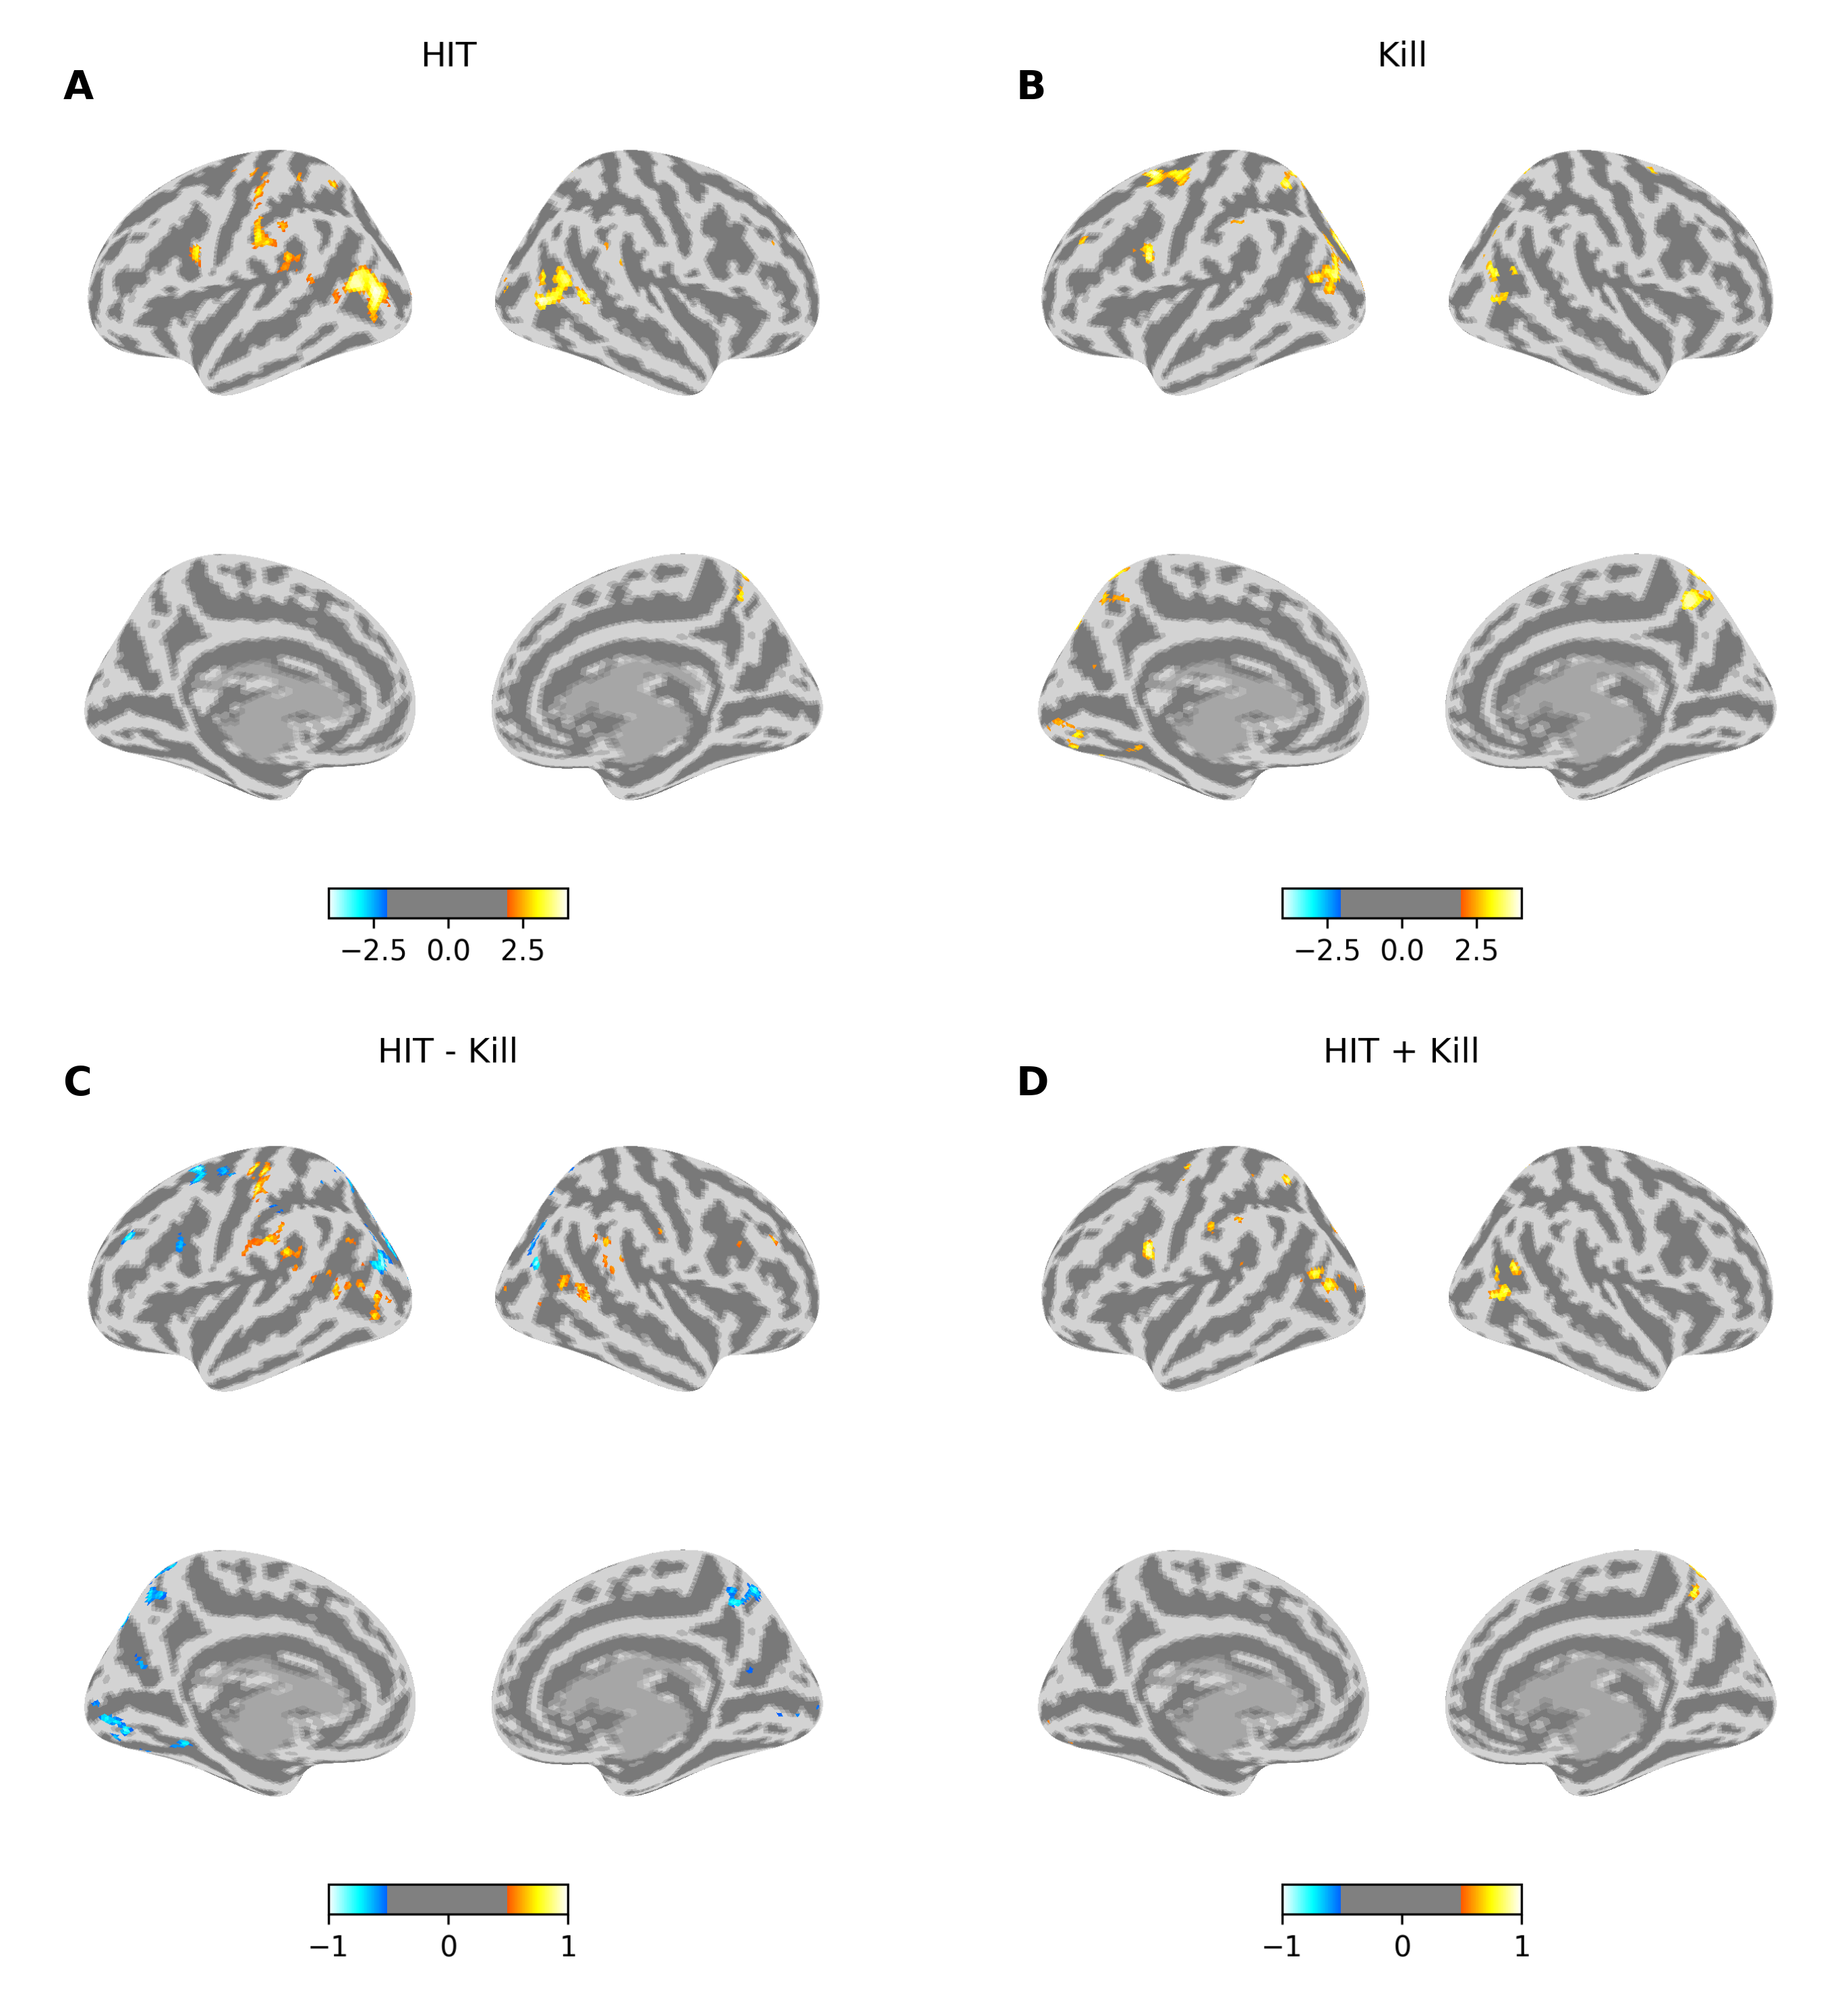

In [124]:
from PIL import Image

annotations = ['HIT', 'Kill', 'HIT-Kill', 'HIT+Kill']

# Make a nice 2 by 2 plot for the conjunction analysis
fig = plt.figure(figsize=(10, 10), dpi=300)
gs = fig.add_gridspec(2, 2)

ax_hit = fig.add_subplot(gs[0, 0])
ax_hit.imshow(Image.open(f'../reports/atlasreader/HIT/conjunction_HIT.png'))
ax_hit.axis('off')

ax_kill = fig.add_subplot(gs[0, 1])
ax_kill.imshow(Image.open(f'../reports/atlasreader/Kill/conjunction_Kill.png'))
ax_kill.axis('off')

ax_hit_min_kill = fig.add_subplot(gs[1, 0])
ax_hit_min_kill.imshow(Image.open(f'../reports/atlasreader/HIT-Kill/conjunction_HIT-Kill.png'))
ax_hit_min_kill.axis('off')

ax_hit_plus_kill = fig.add_subplot(gs[1, 1])
ax_hit_plus_kill.imshow(Image.open(f'../reports/atlasreader/HIT+Kill/conjunction_HIT+Kill.png'))
ax_hit_plus_kill.axis('off')


plt.tight_layout()

#for annot in annotations:
spot_names = string.ascii_uppercase[:4]
for idx, ax in enumerate([ax_hit, ax_kill, ax_hit_min_kill, ax_hit_plus_kill]):
    ax.text(0.05, 0.95, spot_names[idx], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color='black')